**Drive + Dataset ZIP → Local runtime**

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os, zipfile, shutil


ZIP_PATH = "/content/drive/MyDrive/Music_Dataset_Final.zip"
LOCAL_DATA_DIR = "/content/Music_Dataset_Final"

# Clean previous extraction
if os.path.exists(LOCAL_DATA_DIR):
    shutil.rmtree(LOCAL_DATA_DIR)

os.makedirs(LOCAL_DATA_DIR, exist_ok=True)

with zipfile.ZipFile(ZIP_PATH, "r") as z:
    z.extractall(LOCAL_DATA_DIR)

print("Extracted to:", LOCAL_DATA_DIR)


import glob
meta_candidates = glob.glob(LOCAL_DATA_DIR + "/**/metadata.csv", recursive=True)
print("metadata.csv candidates:", meta_candidates[:5])
assert len(meta_candidates) > 0, "metadata.csv not found after unzip"


METADATA = meta_candidates[0]
AUDIO_ROOT = os.path.dirname(METADATA)
print("AUDIO_ROOT:", AUDIO_ROOT)
print("METADATA:", METADATA)


print("Folders:", [d for d in os.listdir(AUDIO_ROOT) if os.path.isdir(os.path.join(AUDIO_ROOT,d))][:20])


Mounted at /content/drive
Extracted to: /content/Music_Dataset_Final
metadata.csv candidates: ['/content/Music_Dataset_Final/metadata.csv']
AUDIO_ROOT: /content/Music_Dataset_Final
METADATA: /content/Music_Dataset_Final/metadata.csv
Folders: ['rock_metal_clips', 'hiphop_clips', 'jazz_clips', 'pop_clips']


In [ ]:
!pip -q install librosa umap-learn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import librosa
import librosa.display

from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

from sklearn.preprocessing import StandardScaler, MaxAbsScaler
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.manifold import TSNE
import umap

from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)


Device: cuda


**Reproducibility + Clustering Metrics (Silhouette/CH/DB/ARI/NMI/Purity)**

In [ ]:
import random, os

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

def cluster_purity(y_true, y_pred):
    y_true = np.asarray(y_true).astype(int)
    y_pred = np.asarray(y_pred).astype(int)
    purity = 0
    n = len(y_true)
    for c in np.unique(y_pred):
        if c == -1:  # DBSCAN noise
            continue
        idx = np.where(y_pred == c)[0]
        if len(idx) == 0:
            continue
        purity += np.max(np.bincount(y_true[idx]))
    return purity / n if n > 0 else 0.0

def safe_silhouette(X, labels):
    labels = np.asarray(labels)
    X = np.asarray(X)
    # remove DBSCAN noise
    mask = labels != -1
    X2 = X[mask]
    y2 = labels[mask]
    if len(np.unique(y2)) < 2:
        return -1.0
    return float(silhouette_score(X2, y2))

def evaluate_all_metrics(X, y_pred, y_true=None):
    out = {}
    out["silhouette"] = safe_silhouette(X, y_pred)
    # CH/DB require >=2 clusters (excluding noise for DBSCAN)
    labels = np.asarray(y_pred)
    mask = labels != -1
    if len(np.unique(labels[mask])) >= 2:
        out["calinski_harabasz"] = float(calinski_harabasz_score(X[mask], labels[mask]))
        out["davies_bouldin"] = float(davies_bouldin_score(X[mask], labels[mask]))
    else:
        out["calinski_harabasz"] = -1.0
        out["davies_bouldin"] = -1.0

    if y_true is not None:
        y_true = np.asarray(y_true).astype(int)
        out["ari"] = float(adjusted_rand_score(y_true, y_pred))
        out["nmi"] = float(normalized_mutual_info_score(y_true, y_pred))
        out["purity"] = float(cluster_purity(y_true, y_pred))
    return out


**Dataset loading + label encoding + path resolver**

In [ ]:
df = pd.read_csv(METADATA)
print(df.head())
print("Total samples:", len(df))
print("Genre counts:\n", df["genre"].value_counts())

def normalize_genre(g):
    return str(g).strip().lower().replace(" ", "_")

# Map genre -> folder
folder_map = {
    "hiphop": "hiphop_clips",
    "rock_metal": "rock_metal_clips",
    "pop": "pop_clips",
    "jazz": "jazz_clips",
}

df["genre_norm"] = df["genre"].apply(normalize_genre)
df["folder"] = df["genre_norm"].map(folder_map)
assert df["folder"].isna().sum() == 0, "Some genres don't match folder_map. Check metadata genre names."

def audio_path_for_row(row):
    return os.path.join(AUDIO_ROOT, row["folder"], row["clip_name"])


missing = 0
for i, row in df.iterrows():
    p = audio_path_for_row(row)
    if not os.path.exists(p):
        missing += 1
        if missing <= 10:
            print("Missing:", p)
print("Total missing files:", missing)
assert missing == 0, "Fix missing paths before proceeding (full-marks strictness)."


genres = df["genre_norm"].astype("category")
y_true = genres.cat.codes.values
genre_names = list(genres.cat.categories)
num_clusters = len(genre_names)
print("num_clusters:", num_clusters, "genre_names:", genre_names)


                                clip_name  \
0  Eminem - Lose Yourself [HD]_part_1.mp3   
1  Eminem - Lose Yourself [HD]_part_2.mp3   
2  Eminem - Lose Yourself [HD]_part_3.mp3   
3  Eminem - Lose Yourself [HD]_part_4.mp3   
4  Eminem - Lose Yourself [HD]_part_5.mp3   

                                              lyrics   genre  
0                                                NaN  hiphop  
1                       Look, if you head, one shot.  hiphop  
2  I won't opportunity I see everything you ever ...  hiphop  
3  But on the surface he looks calm and ready to ...  hiphop  
4  He's so mad but he won't give up that he's he ...  hiphop  
Total samples: 3368
Genre counts:
 genre
rock metal    1068
hiphop        1000
jazz           688
pop            612
Name: count, dtype: int64
Total missing files: 0
num_clusters: 4 genre_names: ['hiphop', 'jazz', 'pop', 'rock_metal']


**Audio Representation for CNN: Log-Mel Spectrogram**

In [ ]:
def extract_logmel(audio_path, sr=22050, n_mels=64, hop_length=512, n_fft=2048, max_len=256):
    y, _sr = librosa.load(audio_path, sr=sr)
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length)
    logmel = librosa.power_to_db(mel).astype(np.float32)  # (n_mels, T)

    # pad/truncate to fixed time length
    T = logmel.shape[1]
    if T < max_len:
        pad = np.zeros((n_mels, max_len - T), dtype=np.float32)
        logmel = np.concatenate([logmel, pad], axis=1)
    else:
        logmel = logmel[:, :max_len]
    return logmel  # (64, max_len)

# Build spectrogram tensor
S = []
for _, row in tqdm(df.iterrows(), total=len(df)):
    S.append(extract_logmel(audio_path_for_row(row)))
S = np.stack(S, axis=0)  # (N, 64, T)
print("Spectrogram tensor:", S.shape)

# Normalize per-feature (global)
S_mean = S.mean()
S_std = S.std() + 1e-6
S_norm = (S - S_mean) / S_std


100%|██████████| 3368/3368 [05:33<00:00, 10.11it/s]


Spectrogram tensor: (3368, 64, 256)


**Lyrics Embedding: TF-IDF (as required hybrid features)**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

def clean_lyrics(x):
    if pd.isna(x): return ""
    x = str(x).lower().strip()
    return "" if x == "music" else x

corpus = [clean_lyrics(x) for x in df["lyrics"].values]
tfidf = TfidfVectorizer(max_features=1000, stop_words="english")
X_lyrics = tfidf.fit_transform(corpus).toarray().astype(np.float32)
print("TF-IDF lyrics:", X_lyrics.shape)

# Reduce lyrics dims for fusion stability
lyrics_red = TruncatedSVD(n_components=128, random_state=42).fit_transform(MaxAbsScaler().fit_transform(X_lyrics))
print("Lyrics reduced:", lyrics_red.shape)


TF-IDF lyrics: (3368, 1000)
Lyrics reduced: (3368, 128)


**Conv VAE for Spectrogram + Fusion with Lyrics (late fusion in latent)**

In [ ]:
class ConvEncoder(nn.Module):
    def __init__(self, n_mels=64, t=256, latent_dim=32):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1), nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), nn.ReLU(),
        )
        # compute flatten dim using dummy
        with torch.no_grad():
            dummy = torch.zeros(1,1,n_mels,t)
            h = self.conv(dummy)
            self.flat_dim = h.view(1,-1).shape[1]
        self.fc = nn.Linear(self.flat_dim, 128)
        self.mu = nn.Linear(128, latent_dim)
        self.logvar = nn.Linear(128, latent_dim)

    def forward(self, x):
        h = self.conv(x)
        h = h.view(h.size(0), -1)
        h = F.relu(self.fc(h))
        return self.mu(h), self.logvar(h)

class LyricsEncoder(nn.Module):
    def __init__(self, in_dim=128, out_dim=32):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 128), nn.ReLU(),
            nn.Linear(128, out_dim), nn.ReLU(),
        )
    def forward(self, x):
        return self.net(x)

class ConvDecoder(nn.Module):
    def __init__(self, n_mels=64, t=256, latent_dim=32, flat_dim=0):
        super().__init__()
        self.n_mels, self.t = n_mels, t
        self.fc1 = nn.Linear(latent_dim, 128)
        self.fc2 = nn.Linear(128, flat_dim)

        # recreate conv output shape via dummy
        self.h_shape = None  # (C,H,W)
    def set_h_shape(self, encoder_conv, n_mels=64, t=256):
        with torch.no_grad():
            dummy = torch.zeros(1,1,n_mels,t)
            h = encoder_conv(dummy)
            self.h_shape = h.shape[1:]  # C,H,W

        C,H,W = self.h_shape
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(C, 32, 4, stride=2, padding=1), nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 4, stride=2, padding=1), nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 4, stride=2, padding=1),
        )

    def forward(self, z):
        h = F.relu(self.fc1(z))
        h = self.fc2(h)
        h = h.view(z.size(0), *self.h_shape)
        x = self.deconv(h)
        # crop to exact size
        return x[:, :, :self.n_mels, :self.t]

class MultimodalConvVAE(nn.Module):
    def __init__(self, n_mels=64, t=256, lyrics_dim=128, latent_dim=32):
        super().__init__()
        self.audio_enc = ConvEncoder(n_mels, t, latent_dim)
        self.lyr_enc = LyricsEncoder(lyrics_dim, latent_dim)
        self.decoder = ConvDecoder(n_mels, t, latent_dim, flat_dim=self.audio_enc.flat_dim)
        self.decoder.set_h_shape(self.audio_enc.conv, n_mels, t)

        # fuse audio+lyrics into shared latent parameters
        self.fuse = nn.Linear(latent_dim*2, latent_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def forward(self, x_audio, x_lyrics):
        mu_a, logvar_a = self.audio_enc(x_audio)
        h_l = self.lyr_enc(x_lyrics)
        # fuse mean/logvar via simple conditioning: add lyrics signal to mu
        mu = self.fuse(torch.cat([mu_a, h_l], dim=1))
        logvar = logvar_a
        z = self.reparameterize(mu, logvar)
        recon = self.decoder(z)
        return recon, mu, logvar

def vae_loss_spec(recon, x, mu, logvar):
    recon_loss = F.mse_loss(recon, x, reduction="sum")
    kl = -0.5*torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl


**Train Medium Model (GPU) + Extract Latent**

In [ ]:
X_audio = torch.tensor(S_norm, dtype=torch.float32).unsqueeze(1)  # (N,1,64,256)
X_lyr = torch.tensor(lyrics_red, dtype=torch.float32)             # (N,128)

loader = DataLoader(TensorDataset(X_audio, X_lyr), batch_size=32, shuffle=True)

model = MultimodalConvVAE(n_mels=64, t=256, lyrics_dim=lyrics_red.shape[1], latent_dim=32).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

epochs = 300
model.train()
for ep in range(1, epochs+1):
    total = 0
    for xa, xl in loader:
        xa, xl = xa.to(device), xl.to(device)
        opt.zero_grad()
        recon, mu, logvar = model(xa, xl)
        loss = vae_loss_spec(recon, xa, mu, logvar)
        loss.backward()
        opt.step()
        total += loss.item()
    if ep % 5 == 0 or ep == 1:
        print(f"Epoch {ep}/{epochs} loss={total/len(df):.4f}")

model.eval()
with torch.no_grad():
    mu_list = []
    for xa, xl in DataLoader(TensorDataset(X_audio, X_lyr), batch_size=64):
        xa, xl = xa.to(device), xl.to(device)
        recon, mu, logvar = model(xa, xl)
        mu_list.append(mu.cpu().numpy())
Z_med = np.concatenate(mu_list, axis=0)
print("Z_med:", Z_med.shape)


Epoch 1/300 loss=8532.1702
Epoch 5/300 loss=4520.6672
Epoch 10/300 loss=4217.6141
Epoch 15/300 loss=4032.3463
Epoch 20/300 loss=3936.8491
Epoch 25/300 loss=3796.1725
Epoch 30/300 loss=3650.0979
Epoch 35/300 loss=3560.9471
Epoch 40/300 loss=3408.7514
Epoch 45/300 loss=3293.4855
Epoch 50/300 loss=3195.2118
Epoch 55/300 loss=3044.1217
Epoch 60/300 loss=2950.1115
Epoch 65/300 loss=2844.0415
Epoch 70/300 loss=2743.1988
Epoch 75/300 loss=2685.6737
Epoch 80/300 loss=2621.1242
Epoch 85/300 loss=2571.9820
Epoch 90/300 loss=2508.3730
Epoch 95/300 loss=2490.9476
Epoch 100/300 loss=2381.9632
Epoch 105/300 loss=2374.8877
Epoch 110/300 loss=2345.1631
Epoch 115/300 loss=2297.4609
Epoch 120/300 loss=2318.2422
Epoch 125/300 loss=2237.1181
Epoch 130/300 loss=2242.2932
Epoch 135/300 loss=2204.0699
Epoch 140/300 loss=2178.6402
Epoch 145/300 loss=2150.5324
Epoch 150/300 loss=2125.8968
Epoch 155/300 loss=2119.4836
Epoch 160/300 loss=2122.9864
Epoch 165/300 loss=2083.3897
Epoch 170/300 loss=2073.8289
Epoch 1

**Clustering Algorithms Comparison (KMeans / Agglo / DBSCAN)**

In [ ]:
from sklearn.preprocessing import StandardScaler

Z_use = StandardScaler().fit_transform(Z_med)

results = []

# KMeans
pred_km = KMeans(n_clusters=num_clusters, random_state=42).fit_predict(Z_use)
results.append({"method":"Medium_ConvVAE+KMeans", **evaluate_all_metrics(Z_use, pred_km, y_true)})

# Agglomerative
pred_ag = AgglomerativeClustering(n_clusters=num_clusters).fit_predict(Z_use)
results.append({"method":"Medium_ConvVAE+Agglo", **evaluate_all_metrics(Z_use, pred_ag, y_true)})

pd.DataFrame(results)


,method,silhouette,calinski_harabasz,davies_bouldin,ari,nmi,purity
0,Medium_ConvVAE+KMeans,0.027120,132.410446,3.763890,0.121936,0.148254,0.503563
1,Medium_ConvVAE+Agglo,-0.020583,85.248215,4.469107,0.090637,0.159866,0.447150


**DBSCAN parameter sweep**

In [ ]:
def dbscan_summary(labels):
    labels = np.asarray(labels)
    n_noise = int(np.sum(labels == -1))
    n_clusters = int(len(set(labels)) - (1 if -1 in labels else 0))
    return n_clusters, n_noise

best = None

for eps in [0.3, 0.5, 0.7, 0.9, 1.2, 1.5]:
    for min_samples in [5, 10, 20]:
        labels = DBSCAN(eps=eps, min_samples=min_samples).fit_predict(Z_use)
        n_clusters, n_noise = dbscan_summary(labels)

        # We only evaluate if we have at least 2 clusters and enough non-noise points
        if n_clusters >= 2 and (len(Z_use) - n_noise) > 50:
            sil = safe_silhouette(Z_use, labels)

            if best is None or sil > best["silhouette"]:
                best = {
                    "eps": eps,
                    "min_samples": min_samples,
                    "n_clusters": n_clusters,
                    "n_noise": n_noise,
                    "silhouette": sil,
                    "labels": labels
                }

print("Best DBSCAN config:", best)


Best DBSCAN config: None


**DBSCAN Diagnostics (Clusters vs Noise)**

In [ ]:
def dbscan_summary(labels):
    labels = np.asarray(labels)
    n_noise = int(np.sum(labels == -1))
    n_clusters = int(len(set(labels)) - (1 if -1 in labels else 0))
    return n_clusters, n_noise

print("DBSCAN diagnostics on normalized latent Z_use")
for eps in [0.2, 0.3, 0.5, 0.7, 0.9, 1.2, 1.5, 2.0]:
    for min_samples in [3, 5, 10, 20, 50]:
        labels = DBSCAN(eps=eps, min_samples=min_samples).fit_predict(Z_use)
        n_clusters, n_noise = dbscan_summary(labels)
        print(f"eps={eps:>3}  min_samples={min_samples:>3}  clusters={n_clusters:>2}  noise={n_noise:>4}")


DBSCAN diagnostics on normalized latent Z_use
eps=0.2  min_samples=  3  clusters= 0  noise=3368
eps=0.2  min_samples=  5  clusters= 0  noise=3368
eps=0.2  min_samples= 10  clusters= 0  noise=3368
eps=0.2  min_samples= 20  clusters= 0  noise=3368
eps=0.2  min_samples= 50  clusters= 0  noise=3368
eps=0.3  min_samples=  3  clusters= 0  noise=3368
eps=0.3  min_samples=  5  clusters= 0  noise=3368
eps=0.3  min_samples= 10  clusters= 0  noise=3368
eps=0.3  min_samples= 20  clusters= 0  noise=3368
eps=0.3  min_samples= 50  clusters= 0  noise=3368
eps=0.5  min_samples=  3  clusters= 0  noise=3368
eps=0.5  min_samples=  5  clusters= 0  noise=3368
eps=0.5  min_samples= 10  clusters= 0  noise=3368
eps=0.5  min_samples= 20  clusters= 0  noise=3368
eps=0.5  min_samples= 50  clusters= 0  noise=3368
eps=0.7  min_samples=  3  clusters= 1  noise=3365
eps=0.7  min_samples=  5  clusters= 0  noise=3368
eps=0.7  min_samples= 10  clusters= 0  noise=3368
eps=0.7  min_samples= 20  clusters= 0  noise=3368
eps=

**Choose DBSCAN eps using k-distance (kNN) curve**

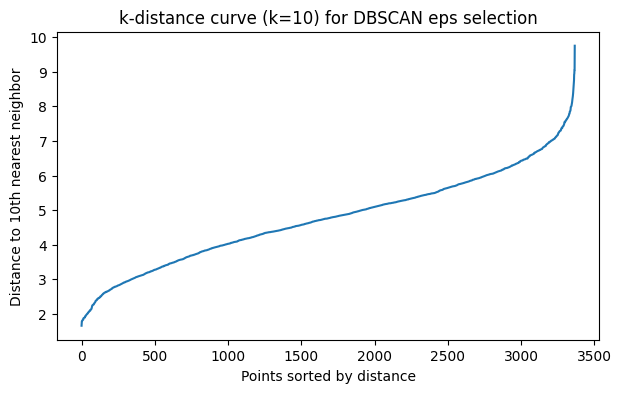

Try eps around the 'elbow' in the curve above.


In [ ]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

k = 10  # corresponds to min_samples
nbrs = NearestNeighbors(n_neighbors=k).fit(Z_use)
distances, indices = nbrs.kneighbors(Z_use)

# distance to kth neighbor
k_dist = np.sort(distances[:, -1])

plt.figure(figsize=(7,4))
plt.plot(k_dist)
plt.title(f"k-distance curve (k={k}) for DBSCAN eps selection")
plt.xlabel("Points sorted by distance")
plt.ylabel(f"Distance to {k}th nearest neighbor")
plt.show()

print("Try eps around the 'elbow' in the curve above.")


**DBSCAN Final Test (eps from k-distance elbow)**

In [ ]:
eps_list = [3.0, 4.0, 5.0, 5.5, 6.0, 6.5, 7.0]
min_samples_list = [5, 10, 20]

def dbscan_summary(labels):
    labels = np.asarray(labels)
    n_noise = int(np.sum(labels == -1))
    n_clusters = int(len(set(labels)) - (1 if -1 in labels else 0))
    return n_clusters, n_noise

best = None

for eps in eps_list:
    for ms in min_samples_list:
        labels = DBSCAN(eps=eps, min_samples=ms).fit_predict(Z_use)
        n_clusters, n_noise = dbscan_summary(labels)
        print(f"eps={eps:>4}  min_samples={ms:>2}  clusters={n_clusters:>2}  noise={n_noise:>4}")

        if n_clusters >= 2 and (len(Z_use) - n_noise) > 50:
            sil = safe_silhouette(Z_use, labels)
            if best is None or sil > best["silhouette"]:
                best = {"eps": eps, "min_samples": ms, "n_clusters": n_clusters, "n_noise": n_noise,
                        "silhouette": sil, "labels": labels}

print("\nBest valid DBSCAN:", best)


eps= 3.0  min_samples= 5  clusters= 5  noise=2713
eps= 3.0  min_samples=10  clusters= 2  noise=2807
eps= 3.0  min_samples=20  clusters= 1  noise=2875
eps= 4.0  min_samples= 5  clusters= 4  noise=1881
eps= 4.0  min_samples=10  clusters= 2  noise=1955
eps= 4.0  min_samples=20  clusters= 1  noise=1995
eps= 5.0  min_samples= 5  clusters= 3  noise= 864
eps= 5.0  min_samples=10  clusters= 1  noise= 904
eps= 5.0  min_samples=20  clusters= 1  noise= 978
eps= 5.5  min_samples= 5  clusters= 4  noise= 475
eps= 5.5  min_samples=10  clusters= 1  noise= 516
eps= 5.5  min_samples=20  clusters= 1  noise= 555
eps= 6.0  min_samples= 5  clusters= 3  noise= 223
eps= 6.0  min_samples=10  clusters= 1  noise= 253
eps= 6.0  min_samples=20  clusters= 1  noise= 273
eps= 6.5  min_samples= 5  clusters= 1  noise=  98
eps= 6.5  min_samples=10  clusters= 1  noise= 117
eps= 6.5  min_samples=20  clusters= 1  noise= 123
eps= 7.0  min_samples= 5  clusters= 1  noise=  36
eps= 7.0  min_samples=10  clusters= 1  noise=  42


**Append Best DBSCAN to Medium Metrics Table**

In [ ]:
if best is not None:
    pred_db_best = best["labels"]
    results.append({
        "method": f"Medium_ConvVAE+DBSCAN(eps={best['eps']},ms={best['min_samples']})",
        **evaluate_all_metrics(Z_use, pred_db_best, y_true)
    })
else:
    print("DBSCAN still did not form >=2 clusters with eps in elbow range.")

df_metrics = pd.DataFrame(results)
df_metrics


,method,silhouette,calinski_harabasz,davies_bouldin,ari,nmi,purity
0,Medium_ConvVAE+KMeans,0.027120,132.410446,3.763890,0.121936,0.148254,0.503563
1,Medium_ConvVAE+Agglo,-0.020583,85.248215,4.469107,0.090637,0.159866,0.447150
2,"Medium_ConvVAE+DBSCAN(eps=5.0,ms=5)",0.279626,14.085663,0.967868,0.045307,0.054111,0.292755


**Visualizations + Reconstruction Examples**

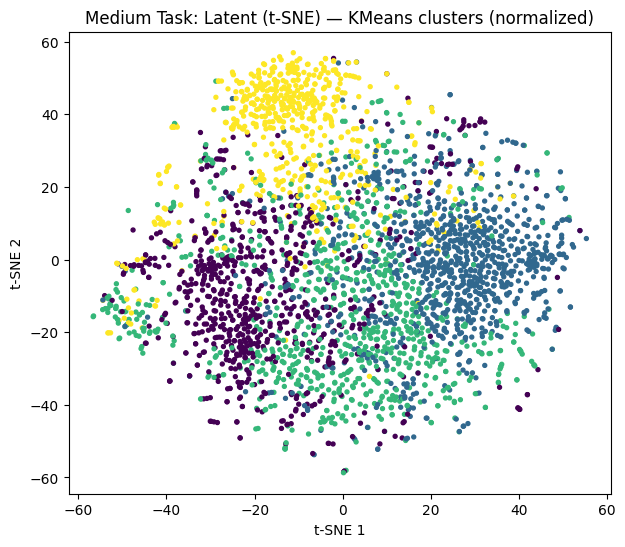

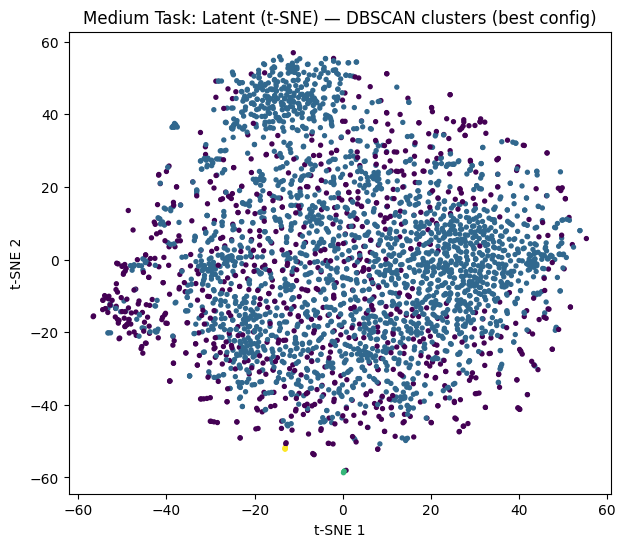

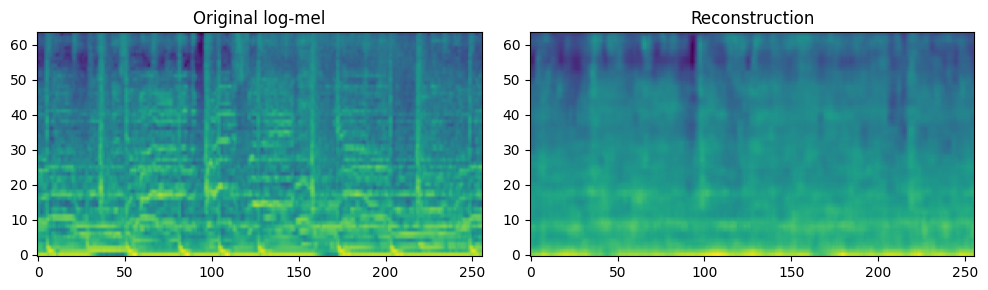

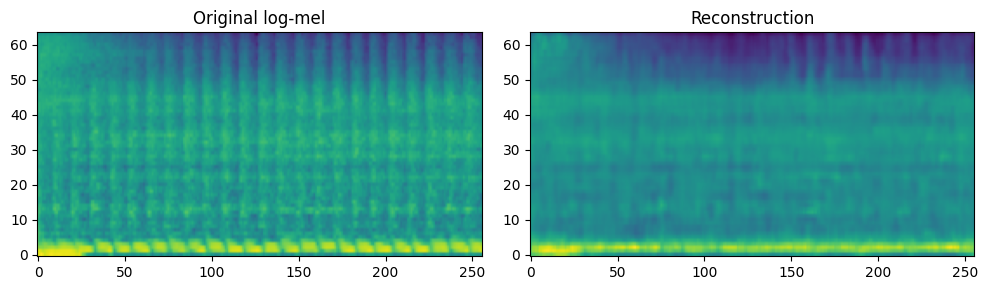

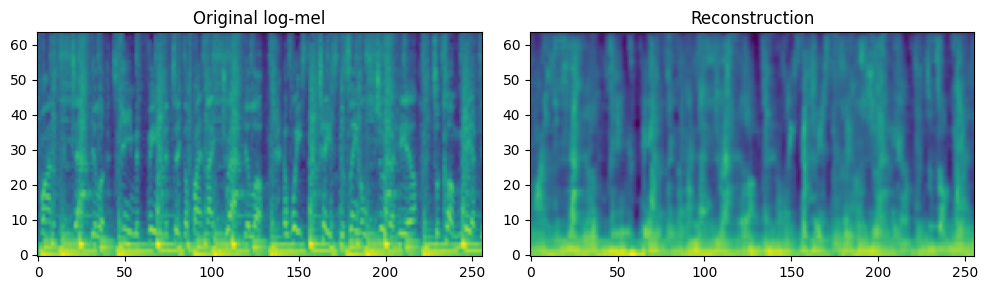

In [ ]:
# -----------------------------
# Latent visualization (t-SNE)
# -----------------------------

Z_2d = TSNE(n_components=2, random_state=42).fit_transform(Z_use)

# Plot 1: KMeans clusters
plt.figure(figsize=(7,6))
plt.scatter(Z_2d[:,0], Z_2d[:,1], c=pred_km, s=8)
plt.title("Medium Task: Latent (t-SNE) — KMeans clusters (normalized)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.show()

# Plot 2: DBSCAN clusters (best config)
if "pred_db_best" in globals():
    plt.figure(figsize=(7,6))
    plt.scatter(Z_2d[:,0], Z_2d[:,1], c=pred_db_best, s=8)
    plt.title("Medium Task: Latent (t-SNE) — DBSCAN clusters (best config)")
    plt.xlabel("t-SNE 1")
    plt.ylabel("t-SNE 2")
    plt.show()
else:
    print("pred_db_best not found — skipping DBSCAN plot (run DBSCAN best-result cell first).")

# --------------------------------
# Reconstruction examples (show 3)
# --------------------------------
model.eval()
with torch.no_grad():
    xa0, xl0 = next(iter(DataLoader(TensorDataset(X_audio, X_lyr), batch_size=3, shuffle=True)))
    xa0, xl0 = xa0.to(device), xl0.to(device)
    recon0, _, _ = model(xa0, xl0)
    xa0 = xa0.cpu().numpy()
    recon0 = recon0.cpu().numpy()

for i in range(3):
    plt.figure(figsize=(10,3))
    plt.subplot(1,2,1)
    plt.imshow(xa0[i,0], aspect="auto", origin="lower")
    plt.title("Original log-mel")
    plt.subplot(1,2,2)
    plt.imshow(recon0[i,0], aspect="auto", origin="lower")
    plt.title("Reconstruction")
    plt.tight_layout()
    plt.show()


**Save Medium Task Outputs (Latents, Clusters, Metrics, Plots)**

Saving Medium results to: /content/results_medium
Saved latent vectors (raw + normalized) and true labels
Saved DBSCAN best clustering labels
Saved clustering labels (KMeans + Agglo)
Saved metrics CSV: /content/results_medium/medium_metrics.csv


,method,silhouette,calinski_harabasz,davies_bouldin,ari,nmi,purity
0,Medium_ConvVAE+KMeans,0.027120,132.410446,3.763890,0.121936,0.148254,0.503563
1,Medium_ConvVAE+Agglo,-0.020583,85.248215,4.469107,0.090637,0.159866,0.447150
2,"Medium_ConvVAE+DBSCAN(eps=5.0,ms=5)",0.279626,14.085663,0.967868,0.045307,0.054111,0.292755


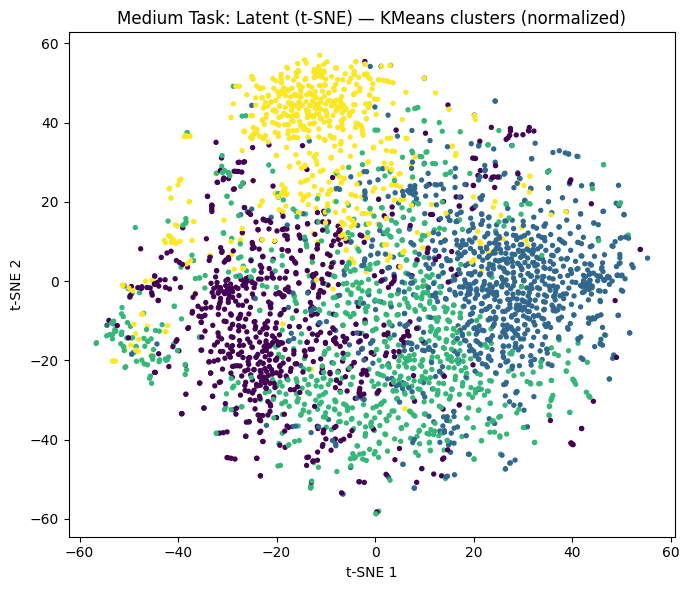

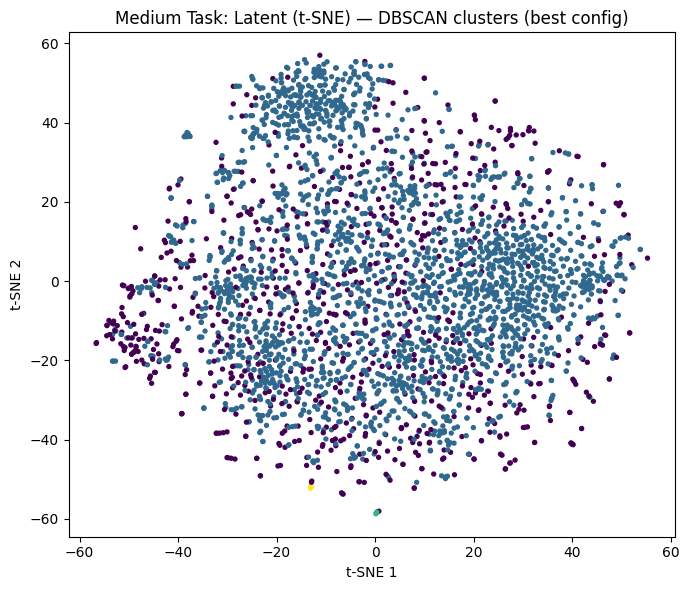

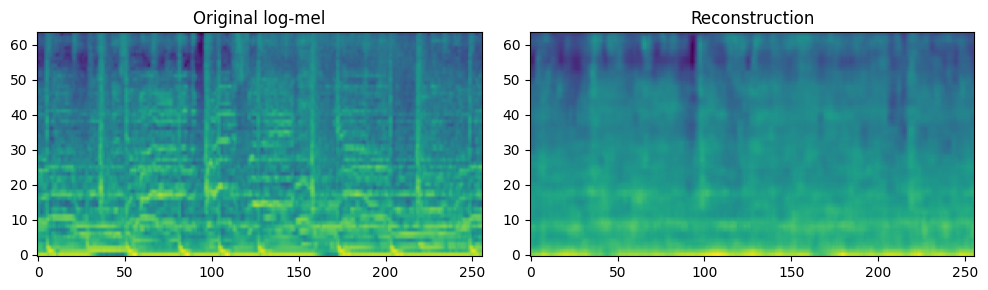

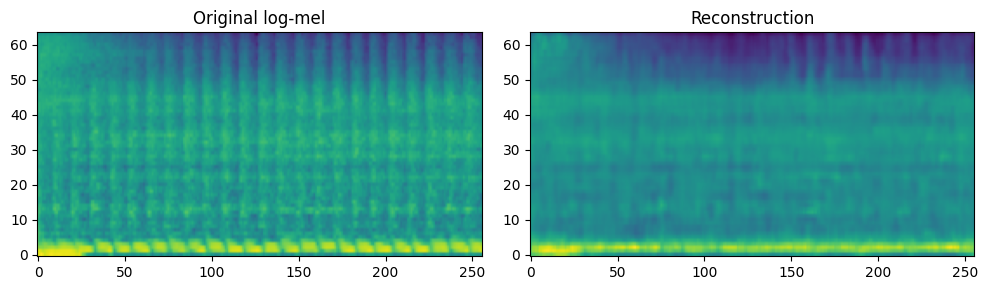

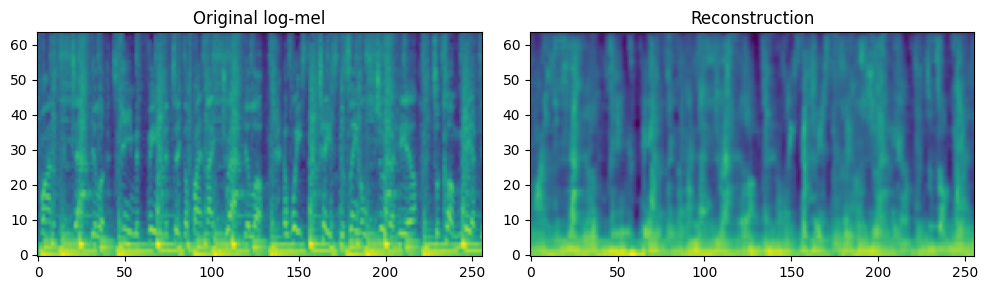

Saved reconstruction images
Zipped: /content/results_medium.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:


OUT_DIR = "/content/results_medium"
os.makedirs(OUT_DIR, exist_ok=True)
print("Saving Medium results to:", OUT_DIR)

# --------------------------
# 1) Save latent + labels
# --------------------------
np.save(os.path.join(OUT_DIR, "Z_medium_convvae.npy"), Z_med)      # raw latent
np.save(os.path.join(OUT_DIR, "Z_medium_convvae_norm.npy"), Z_use) # normalized latent used for clustering
np.save(os.path.join(OUT_DIR, "y_true.npy"), y_true)

print("Saved latent vectors (raw + normalized) and true labels")

# Cluster labels
np.save(os.path.join(OUT_DIR, "clusters_kmeans.npy"), pred_km)
np.save(os.path.join(OUT_DIR, "clusters_agglo.npy"), pred_ag)

# DBSCAN best labels (if available)
if "pred_db_best" in globals():
    np.save(os.path.join(OUT_DIR, "clusters_dbscan_best.npy"), pred_db_best)
    print("Saved DBSCAN best clustering labels")
else:
    print("pred_db_best not found — skipping DBSCAN label save")

print("Saved clustering labels (KMeans + Agglo)")

# --------------------------
# 2) Save metrics table
# --------------------------
# Prefer df_metrics if you created it; otherwise build from `results`
if "df_metrics" in globals():
    metrics_df = df_metrics.copy()
else:
    metrics_df = pd.DataFrame(results)

metrics_df.to_csv(os.path.join(OUT_DIR, "medium_metrics.csv"), index=False)
print("Saved metrics CSV:", os.path.join(OUT_DIR, "medium_metrics.csv"))
display(metrics_df)

# --------------------------
# 3) Save plots (t-SNE)
# --------------------------
# Ensure Z_2d exists (from visualization cell). If not, compute quickly.
if "Z_2d" not in globals():
    from sklearn.manifold import TSNE
    Z_2d = TSNE(n_components=2, random_state=42).fit_transform(Z_use)

# Plot: KMeans
plt.figure(figsize=(7,6))
plt.scatter(Z_2d[:,0], Z_2d[:,1], c=pred_km, s=8)
plt.title("Medium Task: Latent (t-SNE) — KMeans clusters (normalized)")
plt.xlabel("t-SNE 1"); plt.ylabel("t-SNE 2")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "medium_tsne_kmeans.png"), dpi=200)
plt.show()

# Plot: DBSCAN best (optional)
if "pred_db_best" in globals():
    plt.figure(figsize=(7,6))
    plt.scatter(Z_2d[:,0], Z_2d[:,1], c=pred_db_best, s=8)
    plt.title("Medium Task: Latent (t-SNE) — DBSCAN clusters (best config)")
    plt.xlabel("t-SNE 1"); plt.ylabel("t-SNE 2")
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, "medium_tsne_dbscan_best.png"), dpi=200)
    plt.show()

# --------------------------
# 4) Save reconstruction examples
# --------------------------
# xa0 and recon0 should come from the visualization/reconstruction cell.
# If they are missing, warn clearly (don't crash).
if ("xa0" in globals()) and ("recon0" in globals()):
    for i in range(min(3, xa0.shape[0])):
        plt.figure(figsize=(10,3))
        plt.subplot(1,2,1)
        plt.imshow(xa0[i,0], aspect="auto", origin="lower")
        plt.title("Original log-mel")
        plt.subplot(1,2,2)
        plt.imshow(recon0[i,0], aspect="auto", origin="lower")
        plt.title("Reconstruction")
        plt.tight_layout()
        plt.savefig(os.path.join(OUT_DIR, f"reconstruction_{i}.png"), dpi=200)
        plt.show()
    print("Saved reconstruction images")
else:
    print("xa0/recon0 not found — run the 'Visualizations + Reconstruction Examples' cell first to save reconstructions.")

# --------------------------
# 5) Zip + download
# --------------------------
ZIP_PATH = "/content/results_medium.zip"
if os.path.exists(ZIP_PATH):
    os.remove(ZIP_PATH)

shutil.make_archive(ZIP_PATH.replace(".zip",""), "zip", OUT_DIR)
print("Zipped:", ZIP_PATH)

from google.colab import files
files.download(ZIP_PATH)
